<a href="https://colab.research.google.com/github/ronenfeldman/Practicum23/blob/main/yehonatan_cohen/using_hf_flan_base_top500sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import json

# Load the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/MBA/Data Science Practicum 23/final_project/df_500_url.csv")

In [ ]:
# Handle NaN values
df['pdf_text'].fillna('', inplace=True)

# Simple sentence tokenizer based on regex
def simple_sent_tokenize(text):
    sentences = re.split('(?<!\\w\\.\\w.)(?<![A-Z][a-z]\\.)(?<=\\.|\\?)\\s', text)
    return [sent.strip() for sent in sentences if sent]

# Tokenize 'pdf_text' using the simple tokenizer
df['sentences'] = df['pdf_text'].apply(simple_sent_tokenize)

# Expand the DataFrame so that each row contains a single sentence
df_exploded = df.explode('sentences')
df_exploded['sentences'].fillna('', inplace=True)

# Extract company name and year from pdf_name
df_exploded['company_name'] = df_exploded['pdf_name'].str.rsplit('-', n=1).str[0]

In [ ]:
def extract_year(pdf_name):
    # Extract the year using regex
    year = re.search(r'(\d{4})', pdf_name)
    if year:
        year = int(year.group(1))
        # Check if the year falls within the desired range
        if 2000 <= year <= 2023:
            return year
    # Return NaN for anything else
    return float('nan')

# Apply the updated extraction function
df_exploded['report_year'] = df_exploded['pdf_name'].apply(extract_year)

In [ ]:
df_exploded.sample(5)

,pdf_name,url,page_count,text_len,table_of_content,pdf_text,sentences,company_name,report_year
75,ACCO-2021-ESG_FINAL_073122.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,28,48661,"[[1, 'Structure Bookmarks', -1], [2, 'ACCO Bra...",ESG\nREPORT\n2021\nAligning \nToday \nfor a ...,Kids In Need Foundation\nOur Company is proud ...,ACCO-2021,2021.0
447,NYSE_AXP_2019.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,76,203055,[],The Powerful \nBacking of \nAmerican Express...,"In 2019, we set new 2025 environmental goals f...",NYSE_AXP_2019.pdf,2019.0
429,NYSE_AEP_2009.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,72,264279,[],AMERICAN ELECTRIC POWER\n2009 CORPORATE SUSTAI...,Renewable energy resources include: bio-\nmass...,NYSE_AEP_2009.pdf,2009.0
192,NYSE_A_2018.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,56,122243,[],1\nPowered \nby Purpose: \n2018 Corporate Soc...,ON TARGET\n3.,NYSE_A_2018.pdf,2018.0
327,NYSE_ALLY_2020.pdf,https://sust-reports-prod-v1.s3.us-east-2.amaz...,236,989164,"[[1, 'Ally_AnnualReport_FINAL_10k.pdf', 1], [1...",ALLY FINANCIAL | 2020 ANNUAL REPORT\n2020 annu...,Goodwill represents the excess of the cost of ...,NYSE_ALLY_2020.pdf,2020.0


# class

In [ ]:
!pip install langchain
!pip install sentence_transformers
!pip install faiss-gpu

In [ ]:
import textwrap
import pandas as pd
import os
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain import HuggingFacePipeline
from langchain.chains.question_answering import load_qa_chain
from langchain import HuggingFaceHub
from tqdm import tqdm
import concurrent.futures

# Disable tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Singleton for Model Loading
class ModelSingleton:
    _instance = None
    chain = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(ModelSingleton, cls).__new__(cls)
            cls.chain = loadLLMModel()
        return cls._instance

# Loading LLM Model
def loadLLMModel():
    llm = HuggingFacePipeline.from_model_id(model_id="google/flan-t5-base", task="text2text-generation", model_kwargs={"temperature":0.5, "max_length":2000})
    chain = load_qa_chain(llm, chain_type="stuff")
    return chain

# Create Embeddings
embedder = HuggingFaceEmbeddings()
def createEmbeddings(chunked_docs):
    chunked_docs_combined = ['\n'.join(chunked_docs) for chunked_docs in chunked_docs]
    chunked_docs_combined_txt = '\n\n'.join(chunked_docs_combined)
    vector_store = FAISS.from_texts(chunked_docs_combined_txt, embedder)
    return vector_store

# Ask Questions
def askQuestions(vector_store, chain, question):
    similar_docs = vector_store.similarity_search(question)
    response = chain.run(input_documents=similar_docs, question=question)
    return response

# Classify Sentence
model_singleton = ModelSingleton()
chain = model_singleton.chain
def classify_sentence(sentence):
    vector_store = createEmbeddings(sentence)
    response = askQuestions(vector_store, chain,
                            f"""For the follow sentence please classify it into just one of the following 5 categories based on its ESG related content:
                            -'Quantitative Evidence': The sentence contains quantitative evidence that the company already has been taking actions to improve its ESG measures and already implemented the plans. Future plans do NOT count!
                            -'Action Evidence': The sentence contains hard evidence that is not quantitative that the company already has been taking actions to improve its ESG measures and already implemented the plans. Future plans do NOT count!
                            -'Suggestive Evidence': The sentence doesn't contain hard evidence of taking actions to improve the company's ESG measures, but it suggests that such actions have been taken already and have been implemented. Future plans do NOT count!
                            -'Intention': The sentence mentions a company's plans, intentions or commitments of taking actions in the future, without evidence of any actual actions yet.
                            -'Other': The sentence does not match any category.
                            sentence : "{sentence}" """
                           )
    return response

# Parallel Classification using Threads
def parallel_classify_sentences(sentences, chain):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        classifications = list(tqdm(executor.map(classify_sentence, sentences), total=len(sentences)))
    return classifications

# Assuming df_exploded is already loaded
df_exploded_2 = df_exploded[:500]
df_exploded_2['classification'] = parallel_classify_sentences(df_exploded_2['sentences'].tolist(), chain)


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
100%|██████████| 500/500 [1:04:39<00:00,  7.76s/it]
<ipython-input-8-8955bd05f130>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploded_2['classification'] = parallel_classify_sentences(df_exploded_2['sentences'].tolist(), chain)


In [9]:
# Prepare the required DataFrame for CSV export
df_export_2 = df_exploded_2[['pdf_name', 'company_name', 'report_year', 'pdf_text', 'sentences', 'classification']]

# Export to CSV
# df_export.to_csv("classified_sentences.csv", index=False)

In [ ]:
# # Prepare JSON structure and export
# json_data = df_export[['pdf_name', 'company_name', 'report_year', 'sentences', 'classification']].to_dict(orient='records')
# with open("classified_sentences.json", 'w') as json_file:
#     json.dump(json_data, json_file)

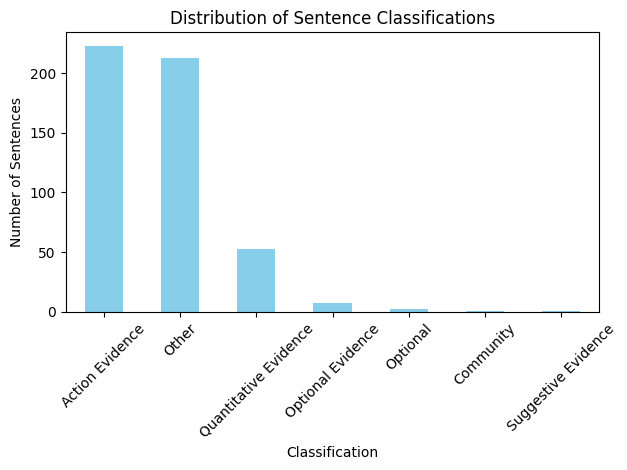

In [11]:
import matplotlib.pyplot as plt
from collections import Counter


# Load the classified sentences CSV
# df = pd.read_csv("classified_sentences.csv")

df = df_export_2

# Distribution Analysis
classification_counts = df['classification'].value_counts()
classification_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentence Classifications')
plt.xlabel('Classification')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

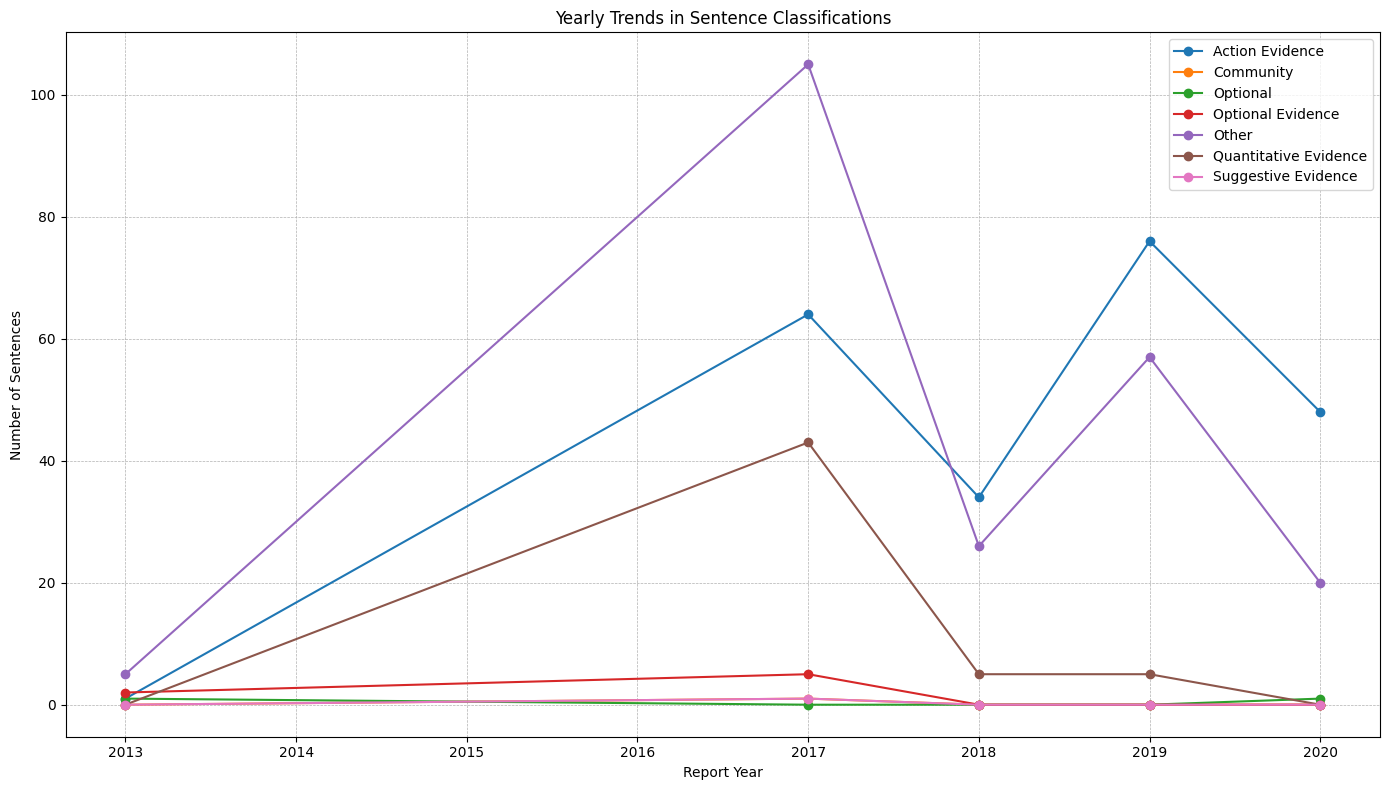

In [12]:
# Yearly trends in classifications
yearly_counts = df.groupby(['report_year', 'classification']).size().unstack().fillna(0)

# Plotting the yearly trends
plt.figure(figsize=(14, 8))
for classification in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[classification], label=classification, marker='o')

plt.title('Yearly Trends in Sentence Classifications')
plt.xlabel('Report Year')
plt.ylabel('Number of Sentences')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

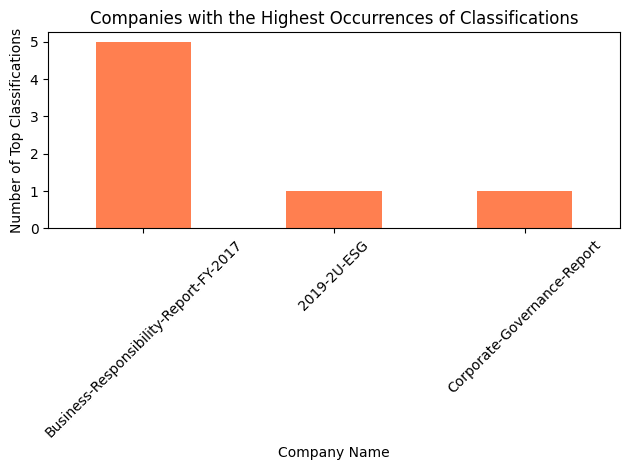

In [13]:
# Company Analysis
top_companies = df.groupby(['company_name', 'classification']).size().unstack().fillna(0)
top_classifications = top_companies.idxmax()
top_classifications.value_counts().plot(kind='bar', color='coral')
plt.title('Companies with the Highest Occurrences of Classifications')
plt.xlabel('Company Name')
plt.ylabel('Number of Top Classifications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-14-a3a1c0e0357c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence Length'] = df['sentences'].apply(len)


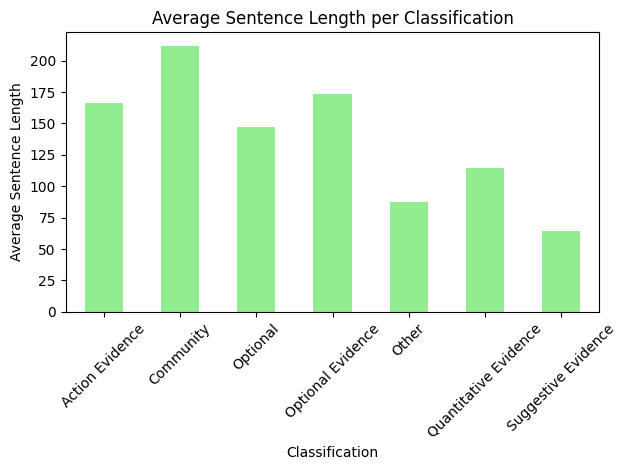

In [14]:
# Sentence Length Analysis
df['Sentence Length'] = df['sentences'].apply(len)
avg_sentence_length = df.groupby('classification')['Sentence Length'].mean()
avg_sentence_length.plot(kind='bar', color='lightgreen')
plt.title('Average Sentence Length per Classification')
plt.xlabel('Classification')
plt.ylabel('Average Sentence Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()